In [1]:
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter
from tqdm import tqdm
import numpy as np
import pandas as pd

In [2]:
sample_dataset = "datasets/sample_emails.csv"

In [4]:
# Read the CSV file and display first 10-15 rows of the 'content' column
df = pd.read_csv(sample_dataset)
print("Sample email contents:")
print("-" * 50)
for i, content in enumerate(df['content'].head(5000)):
    print(f"Email {i+1}:")
    print(content)
    print("-" * 50)

Sample email contents:
--------------------------------------------------
Email 1:
I believe all the bugs have been worked out of this one. It pulls in inter-desk swaps and includes all the features you guys have requested - sorts by delivery point or hour, able to refresh, etc.

I've saved the download as EOL Download (in P://Real Time/Increment/Windows 2000) and deleted the file called NEW EOL DOWNLOAD. Test is out and let me know what you think.

Thanks.

Kate Symes
Real Time Trading Support
Office/503-464-7744
Cell/503-819-2181
Fax/503-464-7996


--------------------------------------------------
Email 2:
Yahoo! News	Edit Breaking News Alerts - Yahoo!
	
	

	Breaking News Alert	 edit
DAMASCUS, Syria _ Pope John Paul II arrives in Syria. 	
	
	Click here!
	[IMAGE]
		


If you no longer wish to receive this alert, click here to unsubscribe.
If you have questions, send us feedback.

Copyright , 1994-2001 Yahoo! Inc. All rights reserved. Yahoo Privacy Policy
-----------------------------

In [5]:



# -----------------------------
# 1. Text Preprocessing Utilities
# -----------------------------

def tokenize(text):
    """Converts input to string, lowercases, and splits by whitespace."""
    if not isinstance(text, str):
        text = str(text)
    return text.lower().split()

def build_vocab(sentences, min_freq=1):
    """Build a vocabulary mapping from token to index."""
    counter = Counter()
    for sent in sentences:
        counter.update(tokenize(sent))
    # Reserve index 0 for padding and 1 for unknown tokens
    vocab = {word: i + 2 for i, (word, count) in enumerate(counter.items()) if count >= min_freq}
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def text_to_indices(text, vocab):
    """Convert text string to a list of token indices."""
    tokens = tokenize(text)
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

In [6]:
# -----------------------------
# 2. Dataset Definition
# -----------------------------

class EmailHierarchyDataset(Dataset):
    """
    Dataset for emails with hierarchy labels.
    Assumes the CSV file has:
      - 'content': preprocessed email text (input)
      - 'hierarchy_label': the hierarchy label (output)
    """
    def __init__(self, csv_file=None, df=None, vocab=None, max_len=100):
        if csv_file is not None:
            self.data = pd.read_csv(csv_file)
        elif df is not None:
            self.data = df
        else:
            raise ValueError("Either csv_file or df must be provided")
            
        # Map the hierarchy_label to an integer index
        self.label_mapping = {
                'Sender higher': 0,
                'Similar level': 1,
                'Recipient higher': 2,
                # 'Unknown': 3
            }
        self.data['label'] = self.data['Hierarchy_Label'].map(self.label_mapping)
        
        # Inverse mapping for result interpretation
        self.idx_to_label = {idx: label for label, idx in self.label_mapping.items()}

        # Build vocabulary if not provided
        if vocab is None:
            self.vocab = build_vocab(self.data['content'].tolist())
        else:
            self.vocab = vocab

        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = row['content']
        label = row['label']
        indices = text_to_indices(text, self.vocab)
        # Pad or truncate the sequence to max_len
        if len(indices) < self.max_len:
            indices = indices + [self.vocab['<PAD>']] * (self.max_len - len(indices))
        else:
            indices = indices[:self.max_len]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

# -----------------------------
# 3. Define the RNN Model with an Embedding Layer
# -----------------------------

class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch_size, sequence_length)
        embedded = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)
        output, hidden = self.rnn(embedded)  # hidden: (num_layers, batch_size, hidden_dim)
        last_hidden = hidden[-1]  # (batch_size, hidden_dim)
        logits = self.fc(last_hidden)  # (batch_size, output_dim)
        return logits

# -----------------------------
# 4. Evaluation Function
# -----------------------------

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for texts, labels in dataloader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)
    return avg_loss, accuracy

In [7]:
# -----------------------------
# 5. Training Setup
# -----------------------------

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
embedding_dim = 256
hidden_dim = 256
num_layers = 2
batch_size = 64
num_epochs = 10
learning_rate = 0.0002
max_len = 200
test_size = 0.2  # 20% of data for testing

# Load the dataset (ensure the CSV file is in your working directory)
full_dataset = EmailHierarchyDataset(sample_dataset, max_len=max_len)

# Split dataset into train and test sets
train_size = int((1 - test_size) * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Determine vocabulary size and number of classes from the dataset
vocab_size = len(full_dataset.vocab)
output_dim = len(full_dataset.label_mapping)

# Print dataset statistics
print(f"Total dataset size: {len(full_dataset)}")
print(f"Training set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")
print(f"Vocabulary size: {vocab_size}")
print(f"Number of classes: {output_dim}")

# Instantiate the model, loss function, and optimizer
model = SimpleRNN(vocab_size, embedding_dim, hidden_dim, output_dim, num_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# -----------------------------
# 6. Training Loop with Progress Bar and Accuracy Tracking
# -----------------------------

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    # Create a progress bar for the current epoch
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for texts, labels in progress_bar:
        texts, labels = texts.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Track statistics
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        train_accuracy = correct / total
        progress_bar.set_postfix({
            'loss': f"{loss.item():.4f}",
            'accuracy': f"{train_accuracy:.4f}"
        })
    
    # Calculate average loss and accuracy for the epoch
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct / total
    
    # Evaluate on test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")



Using device: cuda
Total dataset size: 23970
Training set size: 19176
Test set size: 4794
Vocabulary size: 290656
Number of classes: 3
Starting training...


Epoch 1/10: 100%|██████████| 300/300 [00:12<00:00, 23.21it/s, loss=0.9598, accuracy=0.5646]


Epoch 1/10 - Train Loss: 0.8174, Train Accuracy: 0.5646


Epoch 2/10: 100%|██████████| 300/300 [00:12<00:00, 24.41it/s, loss=0.7269, accuracy=0.5915]


Epoch 2/10 - Train Loss: 0.7875, Train Accuracy: 0.5915


Epoch 3/10: 100%|██████████| 300/300 [00:12<00:00, 24.45it/s, loss=0.7730, accuracy=0.6131]


Epoch 3/10 - Train Loss: 0.7655, Train Accuracy: 0.6131


Epoch 4/10: 100%|██████████| 300/300 [00:12<00:00, 24.44it/s, loss=0.9659, accuracy=0.6324]


Epoch 4/10 - Train Loss: 0.7375, Train Accuracy: 0.6324


Epoch 5/10: 100%|██████████| 300/300 [00:12<00:00, 24.49it/s, loss=0.6979, accuracy=0.6499]


Epoch 5/10 - Train Loss: 0.7081, Train Accuracy: 0.6499


Epoch 6/10: 100%|██████████| 300/300 [00:12<00:00, 24.46it/s, loss=0.5179, accuracy=0.6644]


Epoch 6/10 - Train Loss: 0.6782, Train Accuracy: 0.6644


Epoch 7/10: 100%|██████████| 300/300 [00:12<00:00, 24.44it/s, loss=0.6073, accuracy=0.6794]


Epoch 7/10 - Train Loss: 0.6511, Train Accuracy: 0.6794


Epoch 8/10: 100%|██████████| 300/300 [00:12<00:00, 24.39it/s, loss=0.7731, accuracy=0.6891]


Epoch 8/10 - Train Loss: 0.6306, Train Accuracy: 0.6891


Epoch 9/10: 100%|██████████| 300/300 [00:12<00:00, 24.31it/s, loss=0.9082, accuracy=0.6945]


Epoch 9/10 - Train Loss: 0.6136, Train Accuracy: 0.6945


Epoch 10/10: 100%|██████████| 300/300 [00:12<00:00, 23.93it/s, loss=0.7799, accuracy=0.7000]


Epoch 10/10 - Train Loss: 0.6039, Train Accuracy: 0.7000



Final Test Evaluation:
Test Loss: 1.0880, Test Accuracy: 0.5803



Classification Report:
                  precision    recall  f1-score   support

   Sender higher       0.59      0.90      0.71      2743
   Similar level       0.22      0.09      0.13       145
Recipient higher       0.53      0.16      0.25      1906

        accuracy                           0.58      4794
       macro avg       0.45      0.38      0.36      4794
    weighted avg       0.56      0.58      0.51      4794

Confusion matrix saved as 'confusion_matrix.png'


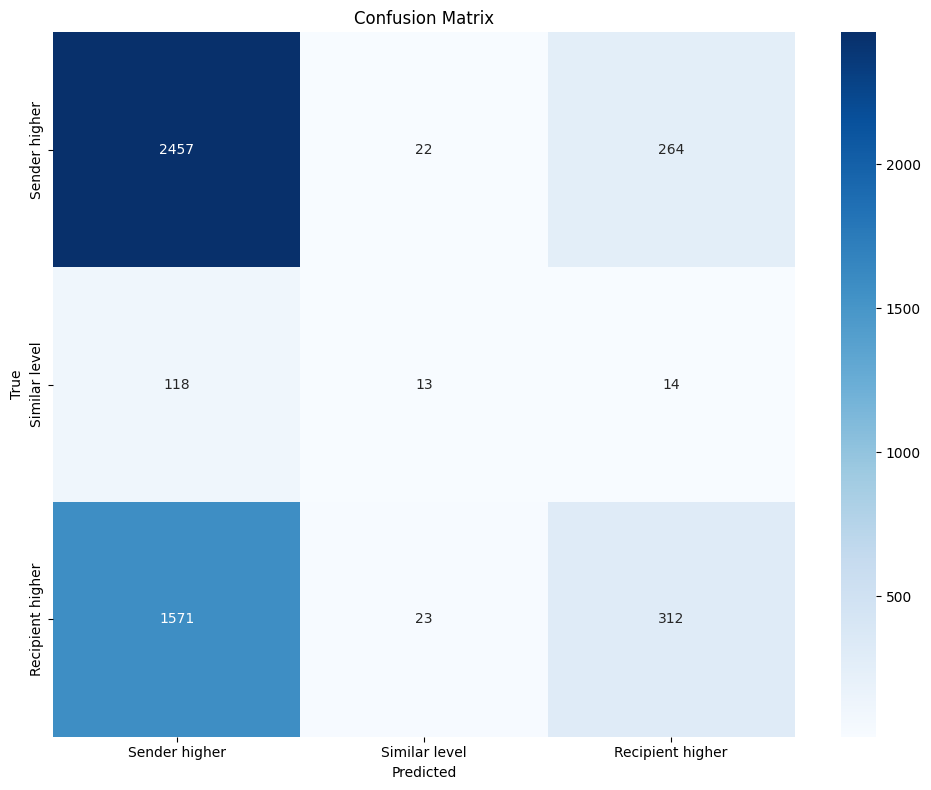

In [8]:
# -----------------------------
# 7. Final Test Evaluation
# -----------------------------

print("\nFinal Test Evaluation:")
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Detailed test evaluation with confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get all predictions and labels
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for texts, labels in tqdm(test_loader, desc="Collecting predictions"):
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts)
        _, predicted = torch.max(outputs.data, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Create classification report
class_names = [full_dataset.idx_to_label[i] for i in range(output_dim)]
report = classification_report(all_labels, all_predictions, target_names=class_names)
print("\nClassification Report:")
print(report)

# Create confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
print("Confusion matrix saved as 'confusion_matrix.png'")



In [9]:
# -----------------------------
# 8. Save the Model
# -----------------------------
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': full_dataset.vocab,
    'label_mapping': full_dataset.label_mapping,
    'idx_to_label': full_dataset.idx_to_label,
    'hyperparameters': {
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'max_len': max_len
    }
}, "rnn_hierarchy_model.pt")
print("Model and metadata saved as 'rnn_hierarchy_model.pt'")

Model and metadata saved as 'rnn_hierarchy_model.pt'
